# Import libraries

In [1]:
import numpy as np
from scipy.spatial import KDTree
import os
import h5py
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from tqdm import tqdm

# Set file paths

In [2]:
# Load TAHMO station data (CSV format with columns:'precipitation')
tahmo_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\TAHMO\TAHMO_export_6704eaa37e81da18c0b7e245'
#model_root_dir = r"D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all" 
model_root_dir = r'D:\Ghana\Merged_files_IMERG_SEVIRI\data_adapted_test_year\test' #r'Z:\cluster_projects\ro\1149_10\earthformer-multisource-to-inca\experiments_adapted130\repotest\testOutput'
#model_root_dir = r'D:\Ghana\Output_data\experiments_adapted130\repotest\testOutput'
#model_root_dir = r"D:/Ghana/Output_data/Earthformer_corrected/2022"

In [3]:
seviri_files = []
# Traverse through all subdirectories and files in the given path
for root, dirs, files in os.walk(model_root_dir):
    for file in files:
        if file.endswith(".hdf5"):
            seviri_files.append(os.path.join(root, file))

# Import TAHMO stationsdata

In [6]:
station_name_list = []
station_data_list_TAHMO = []
for station in os.listdir(tahmo_root_dir): 
    if station.endswith('.csv'):
        station_file = os.path.join(tahmo_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_name_list.append(station.split('.')[0])
        station_data_list_TAHMO.append(station_data)

sensors_meta_data_tahmo = station_data_list_TAHMO.pop(0)
stations_meta_data_tahmo = station_data_list_TAHMO.pop(0)
sensors_meta_data_tahmo_name = station_name_list.pop(0)
stations_meta_data_tahmo_name = station_name_list.pop(0)


station_data_tahmo_dict = dict(zip(station_name_list, station_data_list_TAHMO))

#Assuming df is the DataFrame containing the data
for station_name in station_data_tahmo_dict:
    if station_data_tahmo_dict[station_name].shape[1] == 3:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 2])

        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2]], axis = 1)

        # # Result
        # display(station_data_tahmo_dict[station_name].head())

    elif station_data_tahmo_dict[station_name].shape[1] == 4:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 1]).combine_first(station_data_tahmo_dict[station_name].iloc[:, 3])
        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2, 3]], axis = 1)


    if 'timestamp' in station_data_tahmo_dict[station_name].columns:
        # Set Timestamp as the index
        station_data_tahmo_dict[station_name]['timestamp'] = pd.to_datetime(station_data_tahmo_dict[station_name]['timestamp'])
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].set_index('timestamp')

    # Accumulate over 30 minutes
    station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].resample('30min', label = 'right', closed = 'right').sum(min_count = 2)


# Get the longitude latitude grid

In [7]:
# Load the SEVIRI file to get longitude latitude grid
file_name = 'MSG4-SEVI-MSG15-0100-NA-20200501001242.772000000Z-NA.hdf5'
file_path = fr'C:\Users\c.kwa\Desktop\meteosat_retrieval\SEVIRI_retrieval\Test_batch\Native_to_h5\hdf5\2020\05\{file_name}'
seviri_ds = xr.open_dataset(file_path, engine = 'netcdf4')

# Print dataset information (variables and dimensions)
grid_lat = seviri_ds['y'][:]  [::-1]
grid_lon = seviri_ds['x'][:]

grid_lat = grid_lat.values
grid_lon = grid_lon.values

# Create 2D latitude and longitude grids
grid_lon_2d, grid_lat_2d = np.meshgrid(grid_lon, grid_lat)

grid_lat_2d = np.flipud(grid_lat_2d)

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 248, x: 184)
Coordinates:
  * y        (y) float64 2kB 11.29 11.26 11.23 11.2 ... 4.596 4.569 4.541 4.514
  * x        (x) float64 1kB -3.686 -3.659 -3.631 -3.604 ... 1.281 1.309 1.336
Data variables:
    my_area  int64 8B ...
    IR_016   (y, x) float32 183kB ...
    IR_039   (y, x) float32 183kB ...
    IR_087   (y, x) float32 183kB ...
    IR_097   (y, x) float32 183kB ...
    IR_108   (y, x) float32 183kB ...
    IR_120   (y, x) float32 183kB ...
    IR_134   (y, x) float32 183kB ...
    VIS006   (y, x) float32 183kB ...
    VIS008   (y, x) float32 183kB ...
    WV_062   (y, x) float32 183kB ...
    WV_073   (y, x) float32 183kB ...
Attributes:
    history:      Created by pytroll/satpy on 2024-10-29 20:30:28.976939
    Conventions:  CF-1.7

# Define function to find nearest grid to stations

In [8]:
def nearest_grid_to_stations(grid_lat, grid_lon, station_lat, station_lon):
    """
    Map stations to nearest grid cells using KDTree.
    
    Parameters
    ----------
    grid_lat : numpy.ndarray
        Latitudes of grid cells.
    grid_lon : numpy.ndarray
        Longitudes of grid cells.
    station_lat : numpy.ndarray
        Latitudes of stations.
    station_lon : numpy.ndarray
        Longitudes of stations.
    
    Returns
    -------
    indices : numpy.ndarray
        Indices of grid cells nearest to each station.
    """
    grid_points = np.array(list(zip(grid_lat.ravel(), grid_lon.ravel())))
    station_points = np.array(list(zip(station_lat, station_lon)))
    tree = KDTree(grid_points)
    _, indices = tree.query(station_points)
    return indices

### Create dataframes of the nearest grid cell to stations of all the SEVIRI channels

In [10]:
indices = nearest_grid_to_stations(grid_lat_2d, grid_lon_2d, stations_meta_data_tahmo['latitude'], stations_meta_data_tahmo['longitude'])

dt_list = np.empty(len(seviri_files), dtype=object)
seviri_station_cells = np.zeros((len(seviri_files), len(station_name_list), 11))

# Wrap the loop with tqdm for progress bar
for i, file in enumerate(tqdm(seviri_files, desc="Processing files")):
    try:
        time_str = os.path.basename(file).split('_')[1].split('.')[0]
        # Rearrange timestamp to match nearest timestamp of GMET stations (adjust as needed)
        dt_list[i] = datetime.strptime(time_str, "%Y%m%d%H%M%S") + timedelta(seconds=1)
        with h5py.File(fr'{file}', 'r') as f:
            seviri_data = f['SEVIRI'][-1, :, :, :]
    
            for channel in range(seviri_data.shape[2]):               
                    for k, grid_idx in enumerate(indices):
                        seviri_station_cells[i, k, channel] = np.flipud(seviri_data[:, :, channel]).flat[grid_idx]
                  
    except Exception as e:
        print(f"Error occurred while processing file {file}: {e}")
        for channel in range(seviri_data.shape[2]):
            for k, grid_idx in enumerate(indices):
                seviri_station_cells[i, k, channel] = np.nan

datetime_index = pd.DatetimeIndex(dt_list)
for channel in range(seviri_station_cells.shape[2]):
    df_seviri = pd.DataFrame(seviri_station_cells[:, :, channel], index=datetime_index, columns = station_name_list)
    df_seviri.to_csv(f'df_seviri_tahmo_{channel}_2022.csv')

Processing files: 100%|██████████████████████████████████████████████████████████| 17427/17427 [09:56<00:00, 29.19it/s]


In [12]:
df_seviri_9 = pd.read_csv('df_seviri_tahmo_8_2022.csv', index_col= 0, parse_dates= True)
df_seviri_6 = pd.read_csv('df_seviri_tahmo_5_2022.csv', index_col= 0, parse_dates= True)

Text(0.5, 1.0, 'Multivariate distribution of rainfall and brightness temperature')

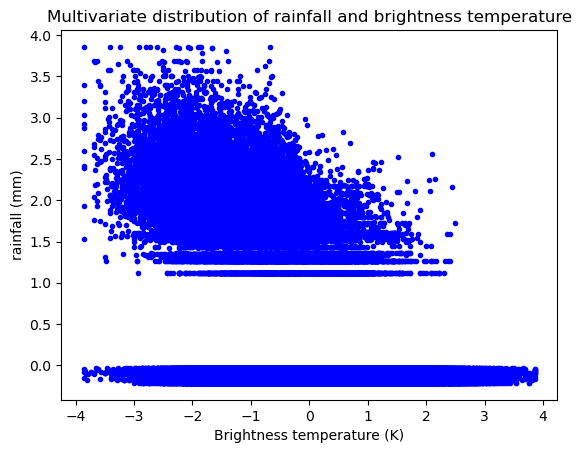

In [18]:
from scipy import stats

def unity(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    return u_hat

def sd_normal(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    sd_data = stats.norm.ppf(u_hat)
    return sd_data


for station_name in station_data_tahmo_dict:
        # Merge the dataframes
        df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)

        # Ensure numeric types for comparison
        #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
        df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')
        
        # Drop rows with NaN values after conversion
        df = df.dropna()
        plt.plot(sd_normal(df[station_name]), sd_normal(df['precipitation (mm)']), 'b.')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
    


(0.0, 1.0)

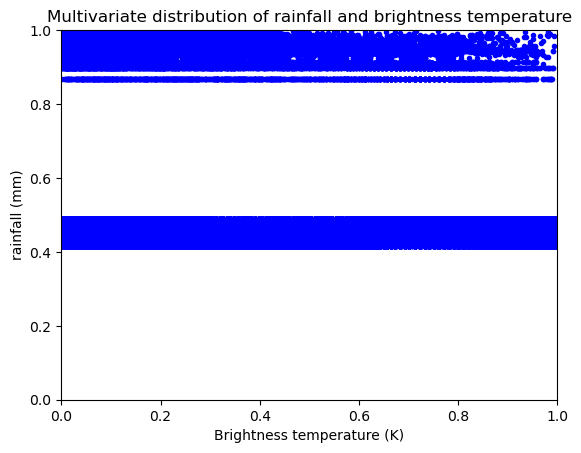

In [19]:
for station_name in station_data_tahmo_dict:
        # Merge the dataframes
        df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)

        # Ensure numeric types for comparison
        #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
        df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')
        
        # Drop rows with NaN values after conversion
        df = df.dropna()
        plt.plot(unity(df[station_name]), unity(df['precipitation (mm)']), 'b.')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
plt.xlim(0, 1)
plt.ylim(0, 1)

skipping TA00007
skipping TA00010
skipping TA00117
skipping TA00254
skipping TA00259
skipping TA00266
skipping TA00302
skipping TA00647
skipping TA00690


(180.0, 350.0)

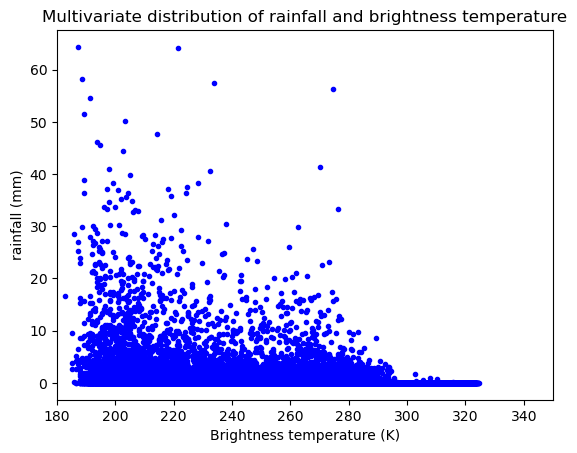

In [24]:
drop_data_tahmo = ['TA00117', 'TA00302', 'TA00007', 'TA00010', 'TA00266', 'TA00259', 'TA00690', 'TA00254', 'TA00647']

for station_name in station_data_tahmo_dict:
    if station_name not in drop_data_tahmo:
            # Merge the dataframes
            df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)
    
            # Ensure numeric types for comparison
            #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
            df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')
            
            # Drop rows with NaN values after conversion
            df = df.dropna()
            plt.plot(df[station_name], df['precipitation (mm)'], 'b.')

    else:
        print(f'skipping {station_name}')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
plt.xlim(180, 350)

skipping TA00007
skipping TA00010
skipping TA00117
skipping TA00254
skipping TA00259
skipping TA00266
skipping TA00302
skipping TA00647
skipping TA00690


(180.0, 350.0)

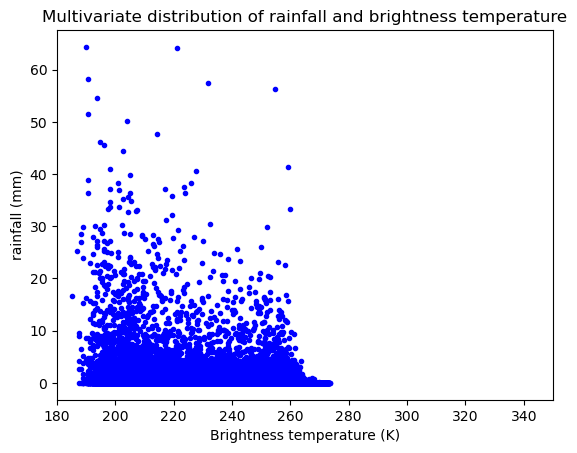

In [26]:
drop_data_tahmo = ['TA00117', 'TA00302', 'TA00007', 'TA00010', 'TA00266', 'TA00259', 'TA00690', 'TA00254', 'TA00647']

for station_name in station_data_tahmo_dict:
    if station_name not in drop_data_tahmo:
            # Merge the dataframes
            df = pd.concat([df_seviri_6[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)
    
            # Ensure numeric types for comparison
            #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
            df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')
            
            # Drop rows with NaN values after conversion
            df = df.dropna()
            plt.plot(df[station_name], df['precipitation (mm)'], 'b.')

    else:
        print(f'skipping {station_name}')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
plt.xlim(180, 350)

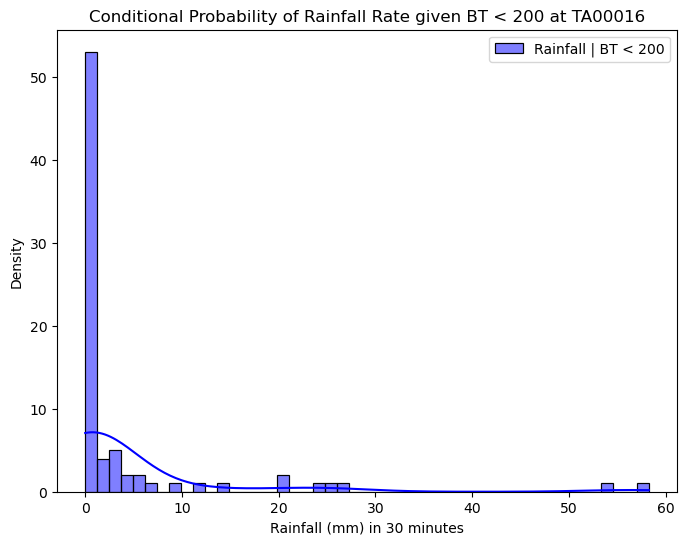

In [28]:
# Define threshold for brightness temperature
threshold = 200

# Filter data where brightness temperature is below the threshold
station_name = 'TA00016'  # Example location

df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)

# Ensure numeric types for comparison
#df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna()

#df[f'Precipitation (mm)'] = np.log1p(df[f'Precipitation (mm)'])  # log(rainfall + 1)
#plt.plot(sd_normal(df[station_name]), sd_normal(df['Precipitation (mm)']), 'b.')


rainfall_below_threshold = df[df[f'{station_name}'] < threshold][f'precipitation (mm)']

# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(rainfall_below_threshold, kde=True, color='blue', label=f'Rainfall | BT < {threshold}')
#sns.histplot(df[f'Precipitation (mm)'], kde=True, color='orange', label='All Rainfall Rates', alpha=0.5)

plt.xlabel('Rainfall (mm) in 30 minutes')
plt.ylabel('Density')
plt.title(f'Conditional Probability of Rainfall Rate given BT < {threshold} at {station_name}')
plt.legend()
plt.show()


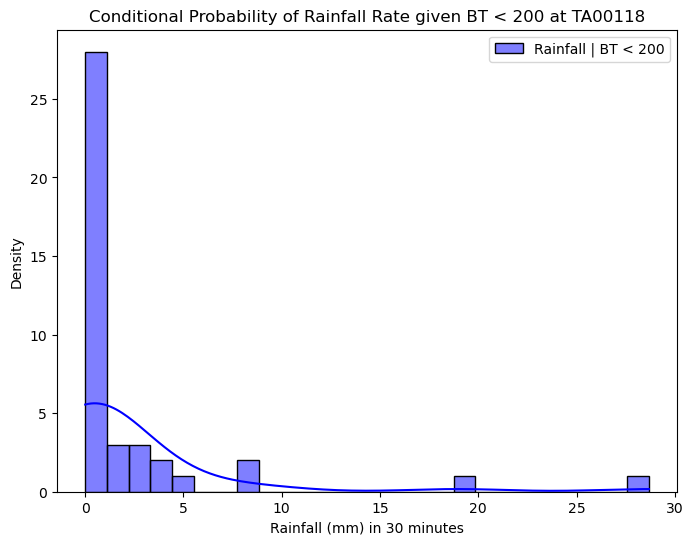

In [31]:
# Define threshold for brightness temperature
threshold = 200

# Filter data where brightness temperature is below the threshold
station_name = 'TA00118'  # Example location

df = pd.concat([df_seviri_6[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)

# Ensure numeric types for comparison
#df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna()

#df[f'Precipitation (mm)'] = np.log1p(df[f'Precipitation (mm)'])  # log(rainfall + 1)
#plt.plot(sd_normal(df[station_name]), sd_normal(df['Precipitation (mm)']), 'b.')


rainfall_below_threshold = df[df[f'{station_name}'] < threshold][f'precipitation (mm)']

# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(rainfall_below_threshold, kde=True, color='blue', label=f'Rainfall | BT < {threshold}')
#sns.histplot(df[f'Precipitation (mm)'], kde=True, color='orange', label='All Rainfall Rates', alpha=0.5)

plt.xlabel('Rainfall (mm) in 30 minutes')
plt.ylabel('Density')
plt.title(f'Conditional Probability of Rainfall Rate given BT < {threshold} at {station_name}')
plt.legend()
plt.show()


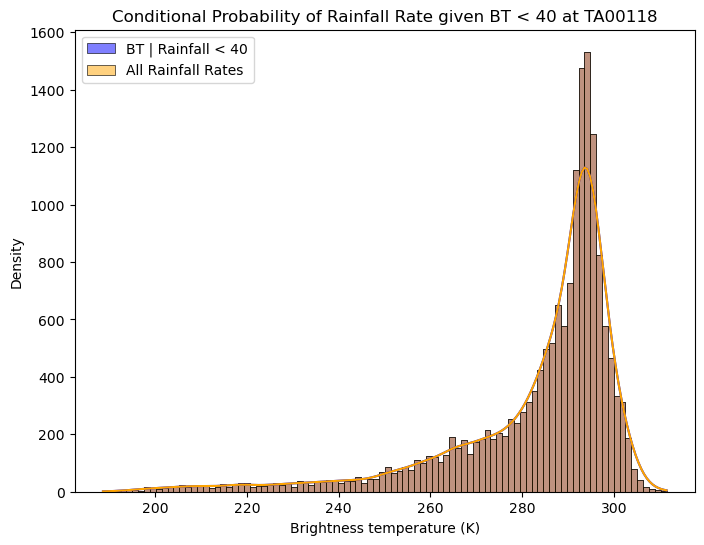

In [32]:
# Define threshold for brightness temperature
threshold = 40

# Filter data where brightness temperature is below the threshold
station_name = 'TA00118'  # Example location

df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)

# Ensure numeric types for comparison
#df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna()

#df[f'Precipitation (mm)'] = np.log1p(df[f'Precipitation (mm)'])  # log(rainfall + 1)
#plt.plot(sd_normal(df[station_name]), sd_normal(df['Precipitation (mm)']), 'b.')


#rainfall_below_threshold = df[df[f'Precipitation (mm)'] < threshold][f'{station_name}']
bt_given_low_rainfall = df[df['precipitation (mm)'] < threshold][station_name]


# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(bt_given_low_rainfall, kde=True, color='blue', label=f'BT | Rainfall < {threshold}')
sns.histplot(df[f'{station_name}'], kde=True, color='orange', label='All Rainfall Rates', alpha=0.5)

plt.xlabel('Brightness temperature (K)')
plt.ylabel('Density')
plt.title(f'Conditional Probability of Rainfall Rate given BT < {threshold} at {station_name}')
plt.legend()
plt.show()

TA00005               float64
precipitation (mm)    float64
dtype: object


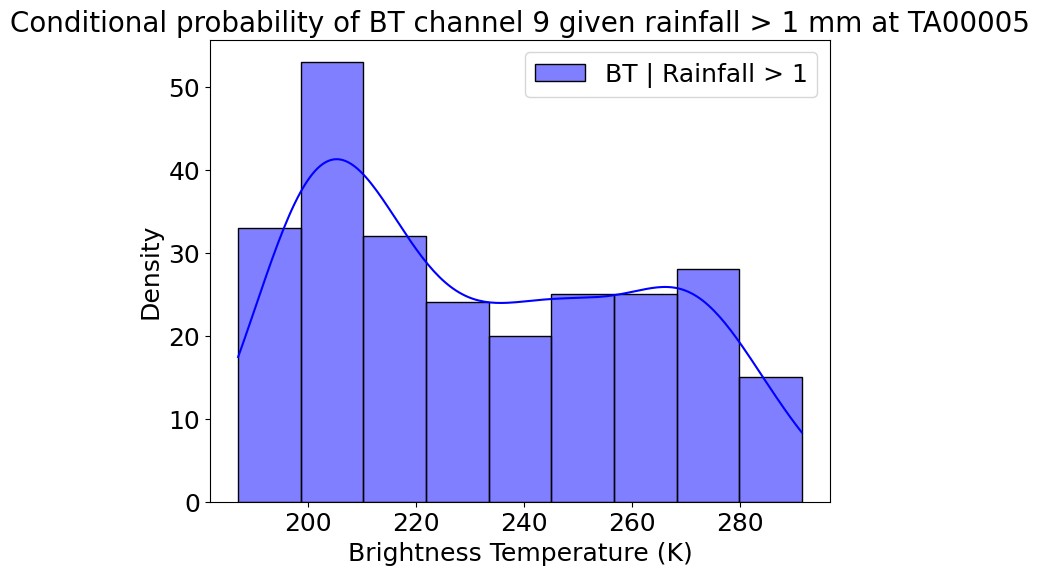

TA00007               float64
precipitation (mm)    float64
dtype: object


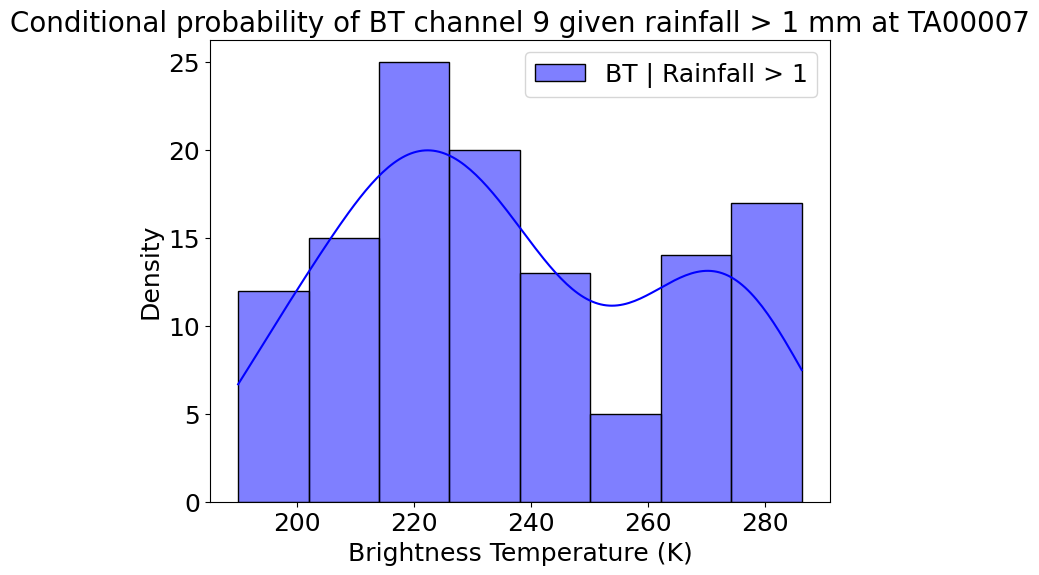

TA00010               float64
precipitation (mm)    float64
dtype: object


C:\Users\c.kwa\AppData\Local\Temp\ipykernel_11228\857970200.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = 18)


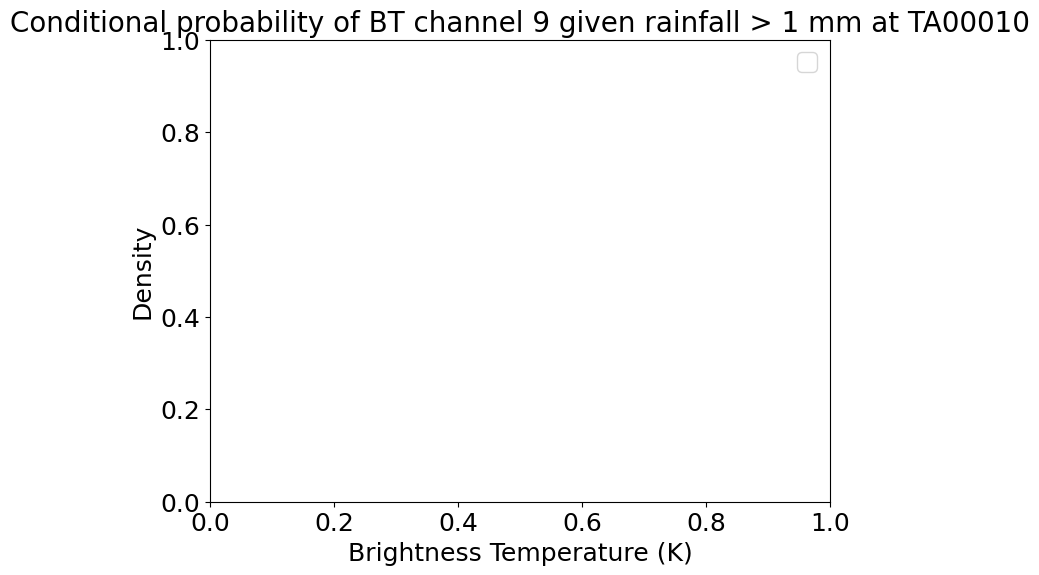

TA00016               float64
precipitation (mm)    float64
dtype: object


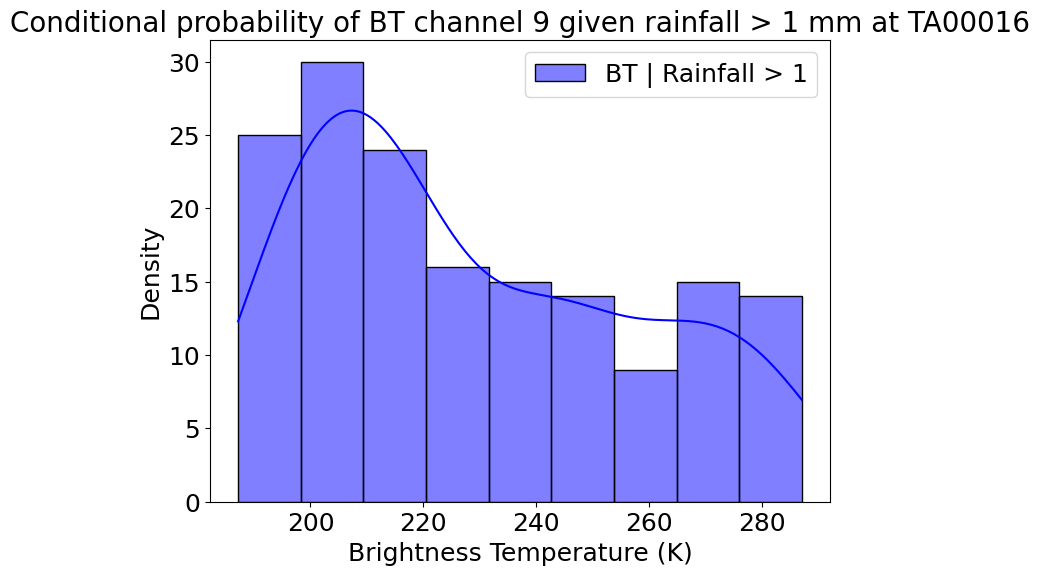

TA00045               float64
precipitation (mm)    float64
dtype: object


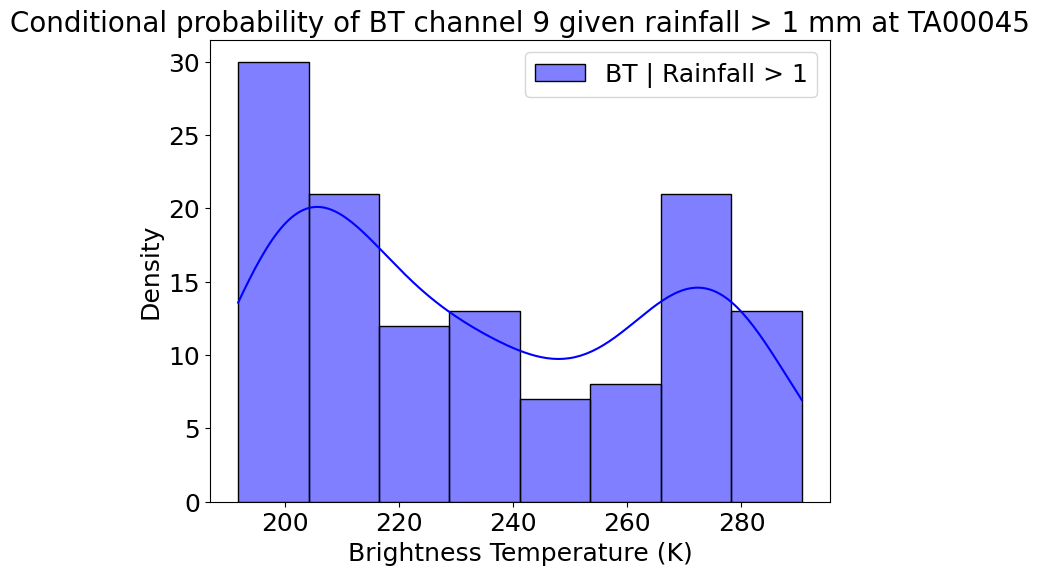

TA00113               float64
precipitation (mm)    float64
dtype: object


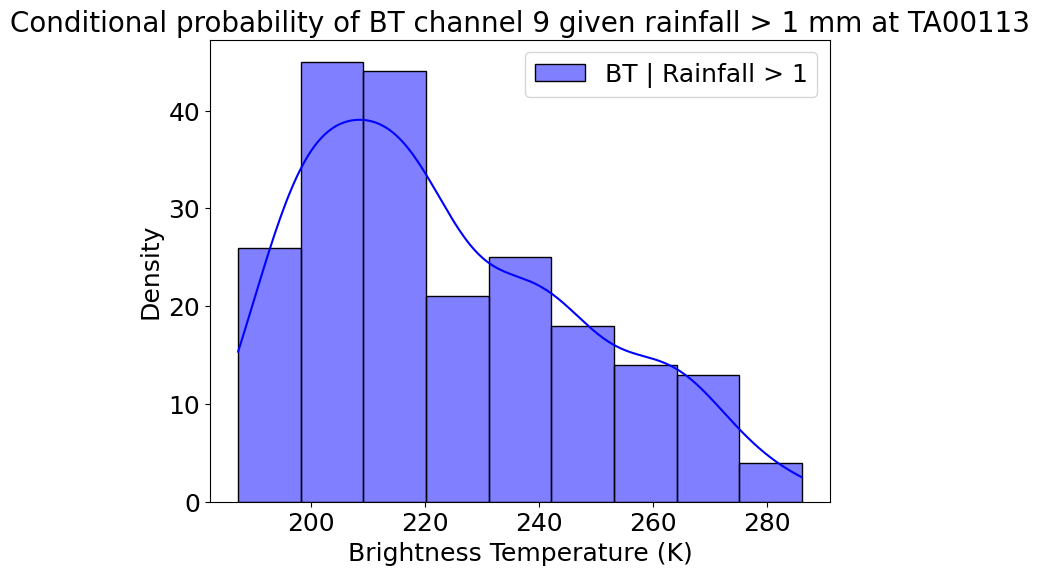

TA00116               float64
precipitation (mm)    float64
dtype: object


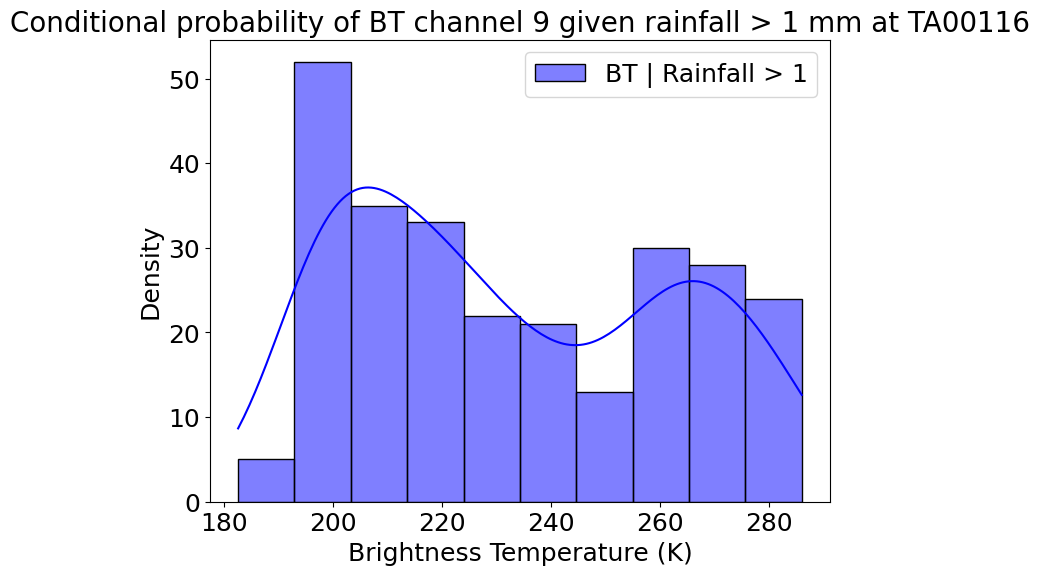

TA00117               float64
precipitation (mm)    float64
dtype: object


C:\Users\c.kwa\AppData\Local\Temp\ipykernel_11228\857970200.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = 18)


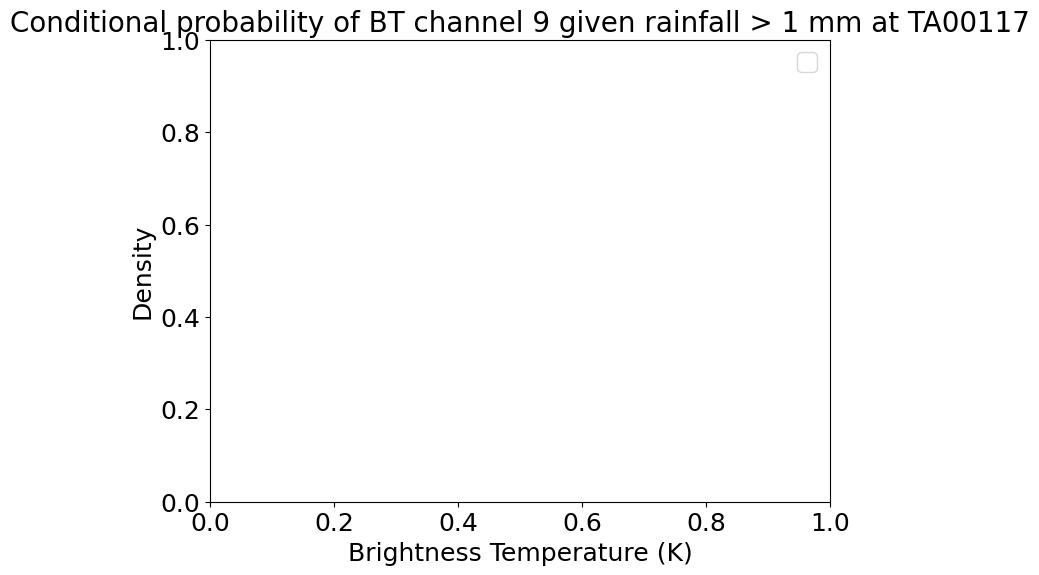

TA00118               float64
precipitation (mm)    float64
dtype: object


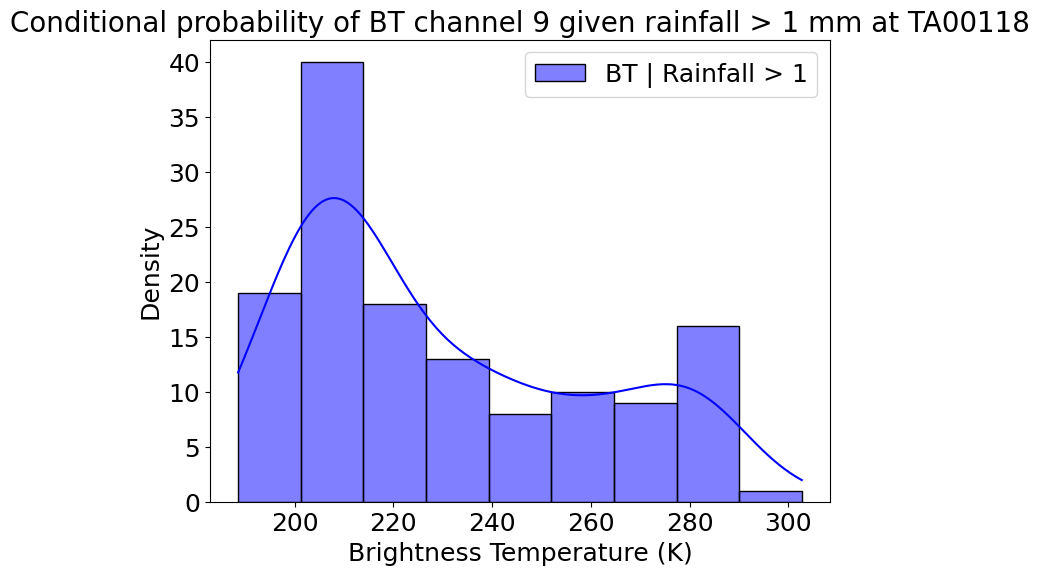

TA00120               float64
precipitation (mm)    float64
dtype: object


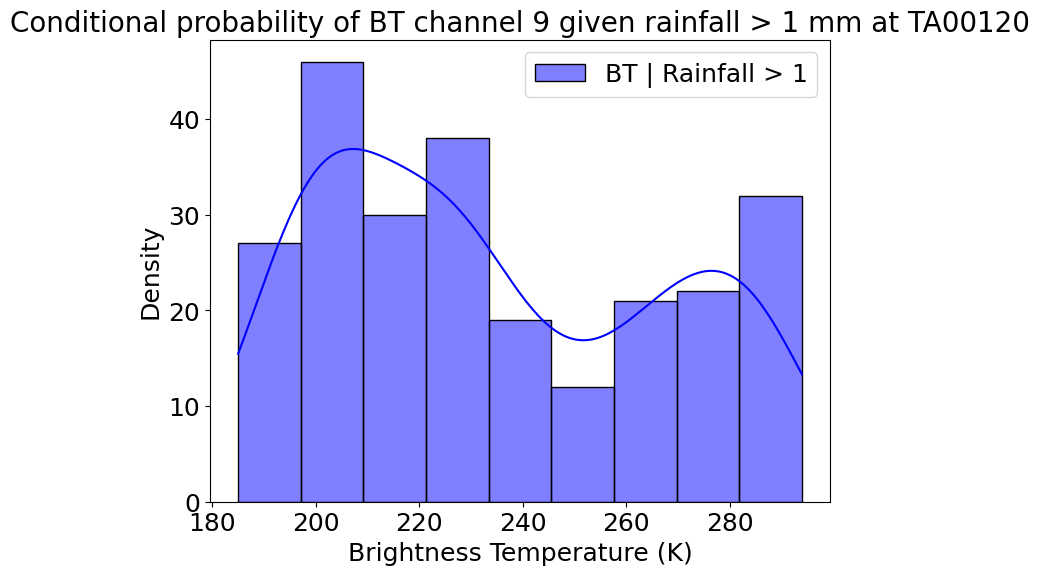

TA00121               float64
precipitation (mm)    float64
dtype: object


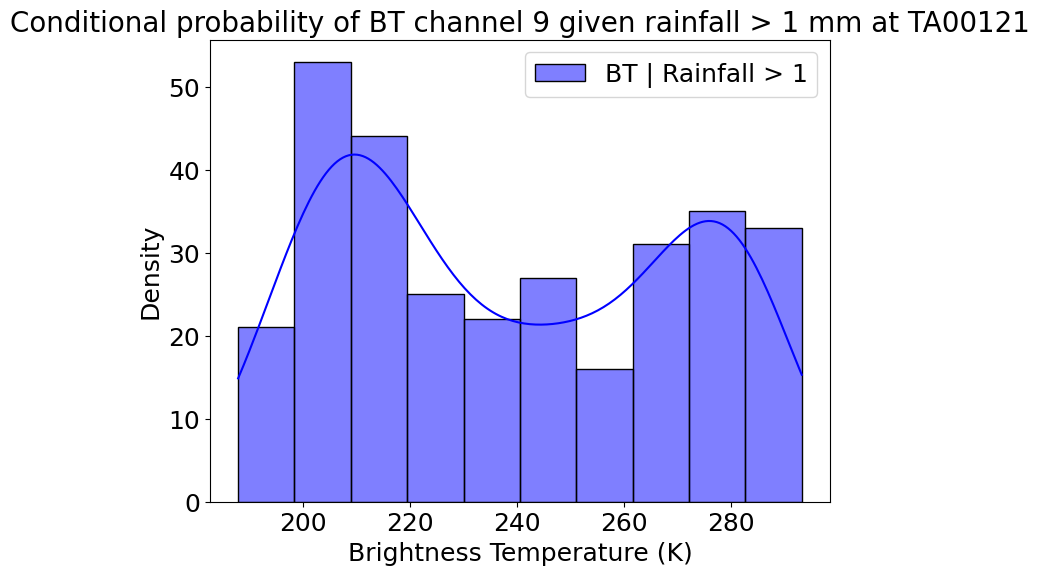

TA00136               float64
precipitation (mm)    float64
dtype: object


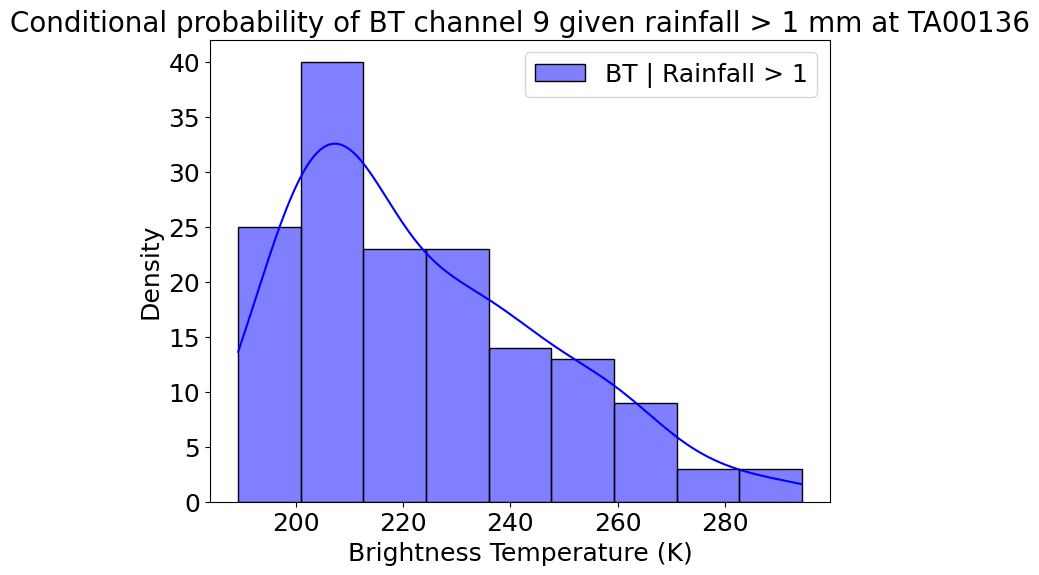

TA00251               float64
precipitation (mm)    float64
dtype: object


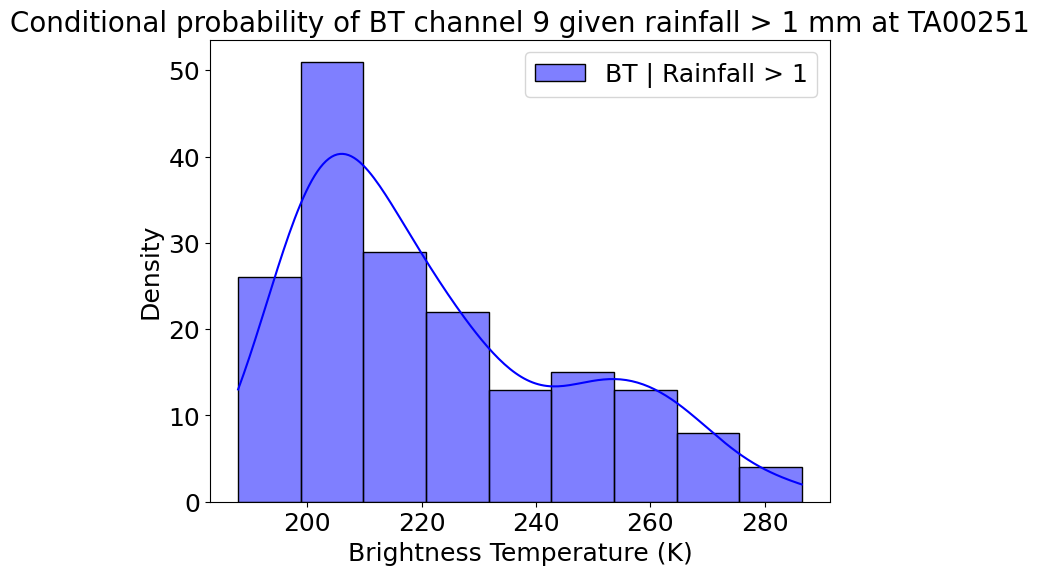

TA00254               float64
precipitation (mm)    float64
dtype: object


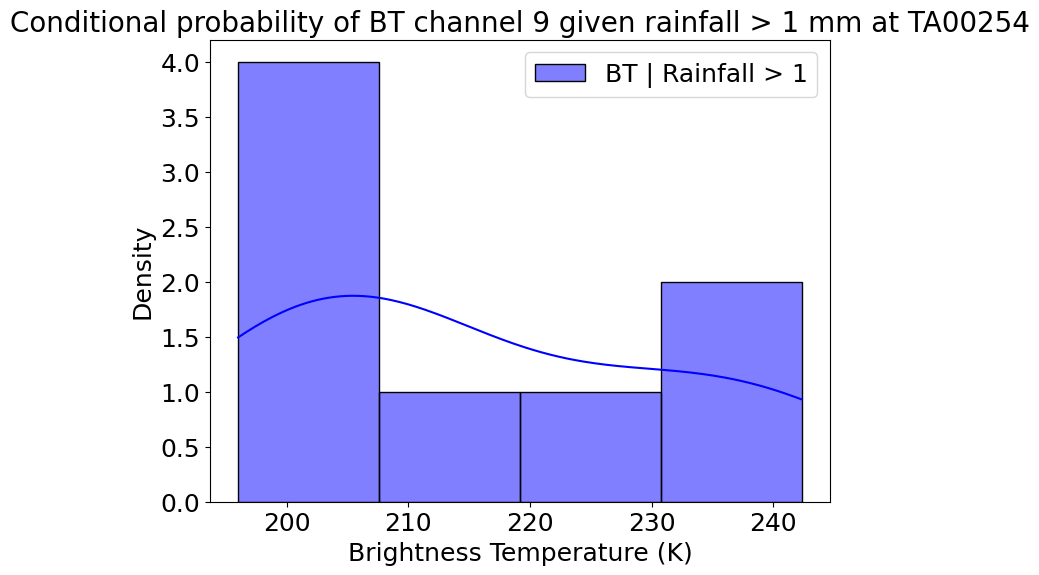

TA00259               float64
precipitation (mm)    float64
dtype: object


C:\Users\c.kwa\AppData\Local\Temp\ipykernel_11228\857970200.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = 18)


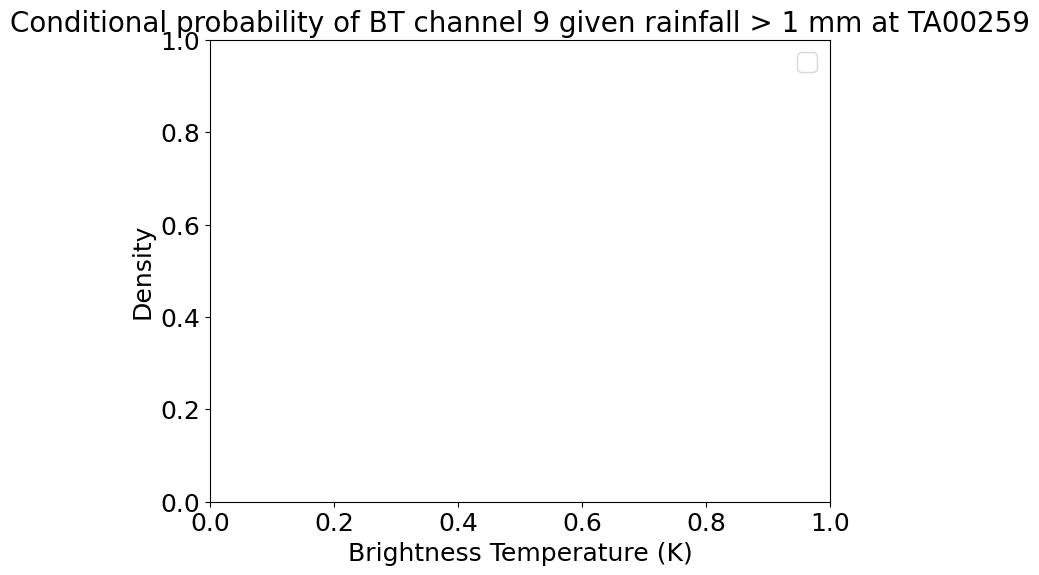

TA00266               float64
precipitation (mm)    float64
dtype: object


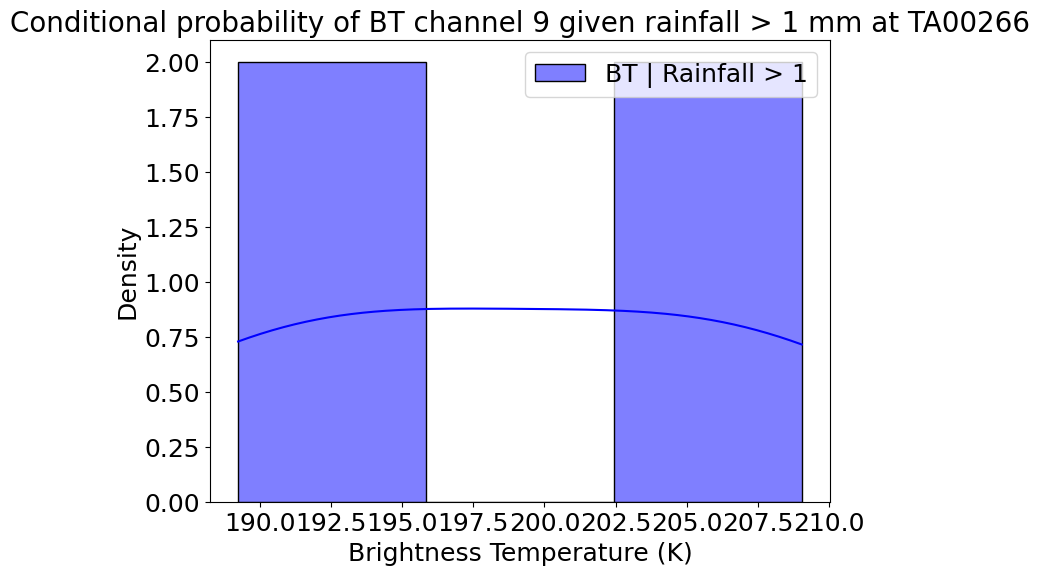

TA00301               float64
precipitation (mm)    float64
dtype: object


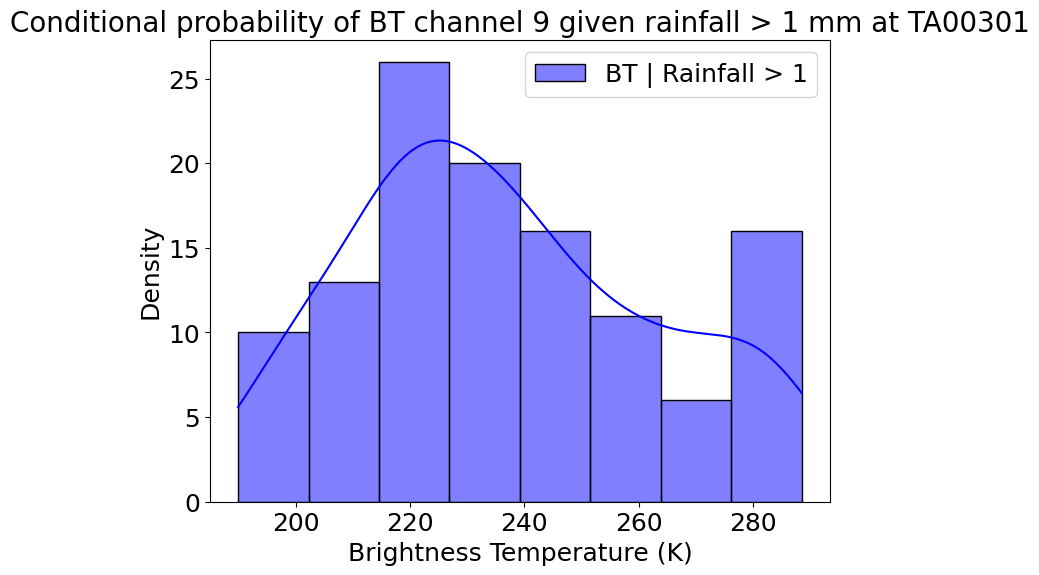

TA00302               float64
precipitation (mm)    float64
dtype: object


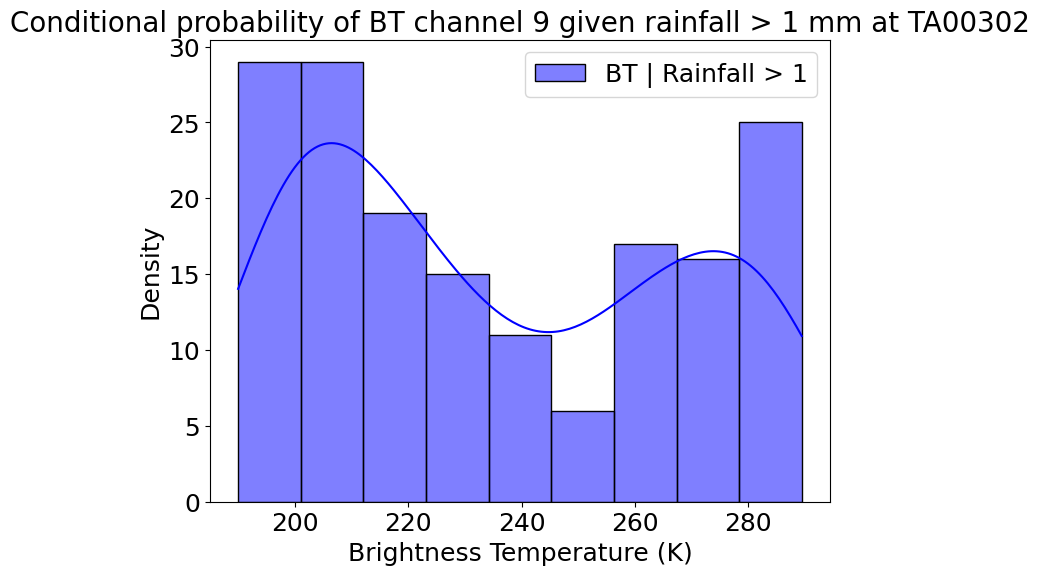

TA00391               float64
precipitation (mm)    float64
dtype: object


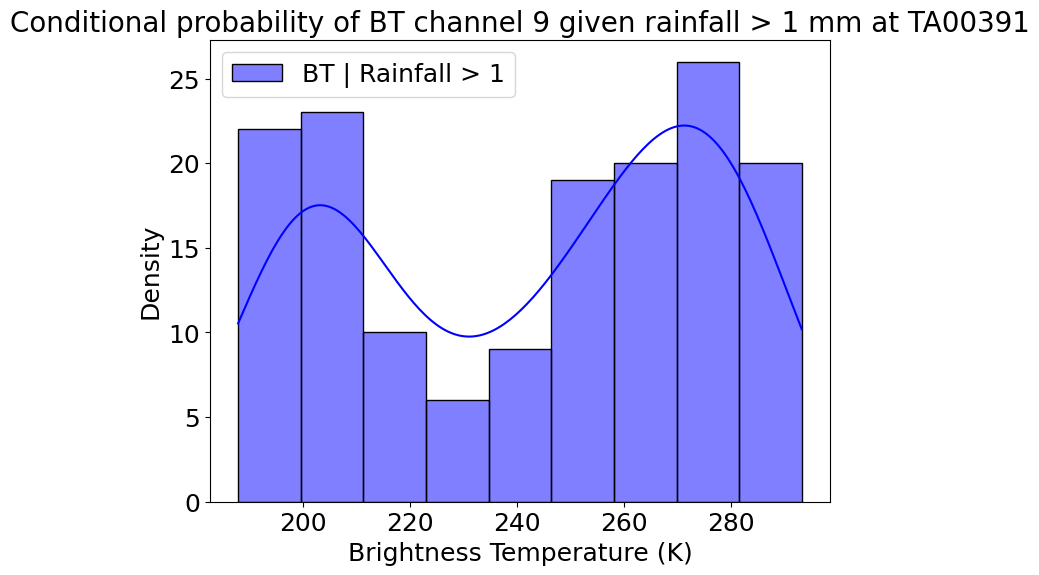

TA00392               float64
precipitation (mm)    float64
dtype: object


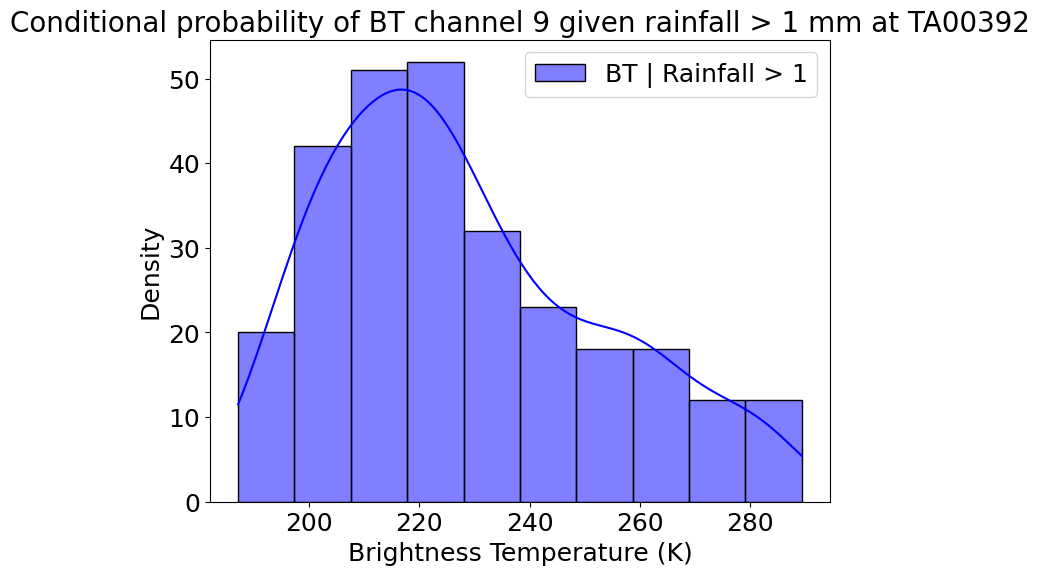

TA00616               float64
precipitation (mm)    float64
dtype: object


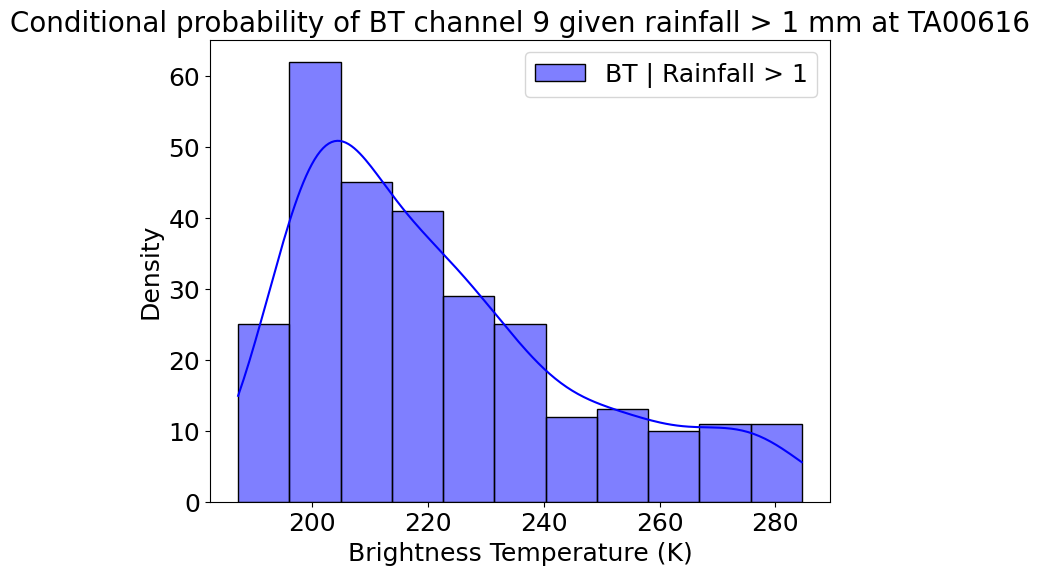

TA00647               float64
precipitation (mm)    float64
dtype: object


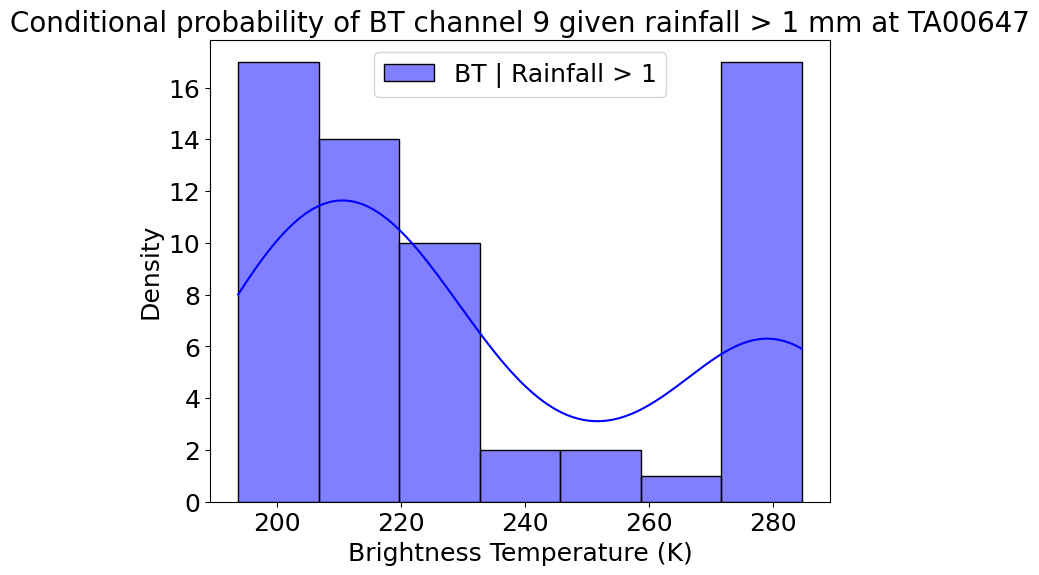

TA00689               float64
precipitation (mm)    float64
dtype: object


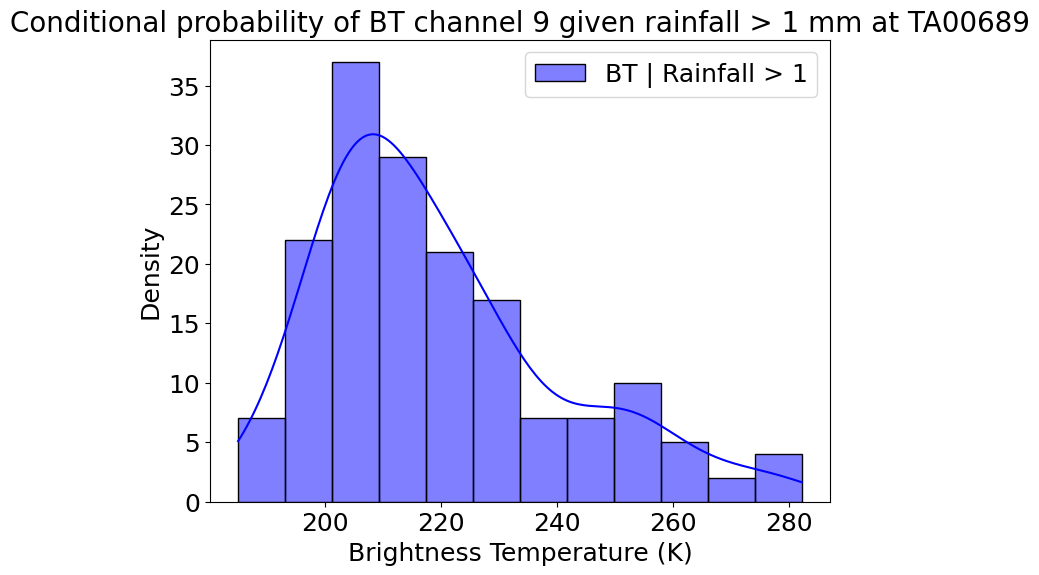

TA00690               float64
precipitation (mm)    float64
dtype: object


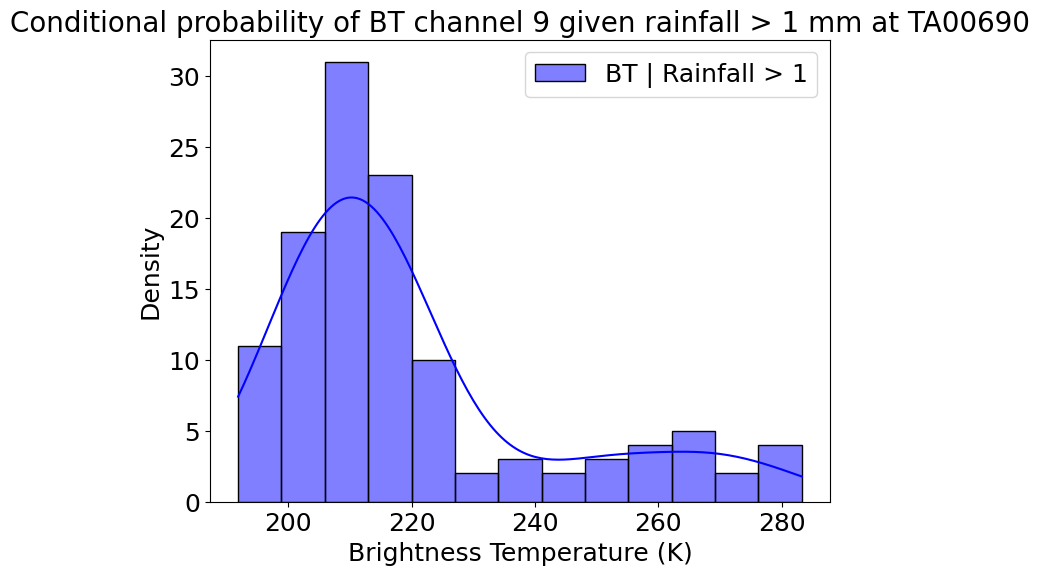

TA00756               float64
precipitation (mm)    float64
dtype: object


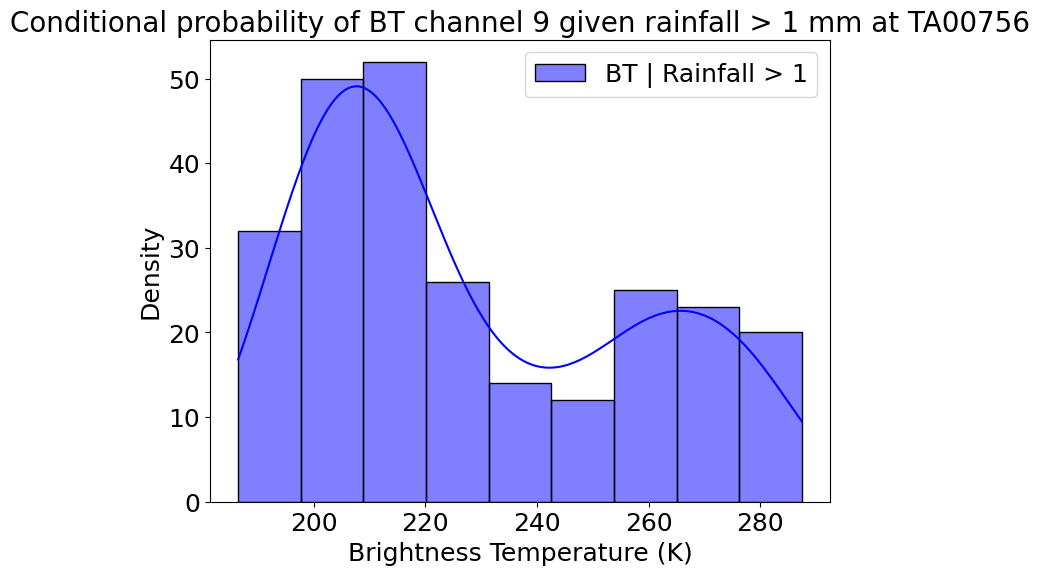

In [67]:
# Define threshold for rainfall (in mm)
threshold = 1


for station_name in station_data_tahmo_dict:
# # Example station name
# station_name = 'TA00136'

    # Combine brightness temperature and rainfall data
    df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)
    
    # Ensure numeric types and drop NaNs
    df['precipitation (mm)'] = pd.to_numeric(df['precipitation (mm)'], errors='coerce')
    df = df.dropna()
    
    print(df.dtypes)
    
    
    # Filter data where rainfall is below the threshold
    bt_given_low_rainfall = df[df['precipitation (mm)'] > threshold][station_name]
    
    # Visualization
    plt.figure(figsize=(8, 6))
    sns.histplot(bt_given_low_rainfall, kde=True, color='blue', label=f'BT | Rainfall > {threshold}')
    #sns.histplot(df[station_name], kde=True, color='orange', label='All Brightness Temperatures', alpha=0.5)
    
    plt.xlabel('Brightness Temperature (K)', fontsize = 18)
    plt.ylabel('Density', fontsize = 18)
    plt.title(f'Conditional probability of BT channel 9 given rainfall > {threshold} mm at {station_name}', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.savefig(f'Conditional_Probability_threshold_{threshold}_{station_name}.png', bbox_inches = 'tight', dpi = 300)
    plt.legend(fontsize = 18)
    plt.show()


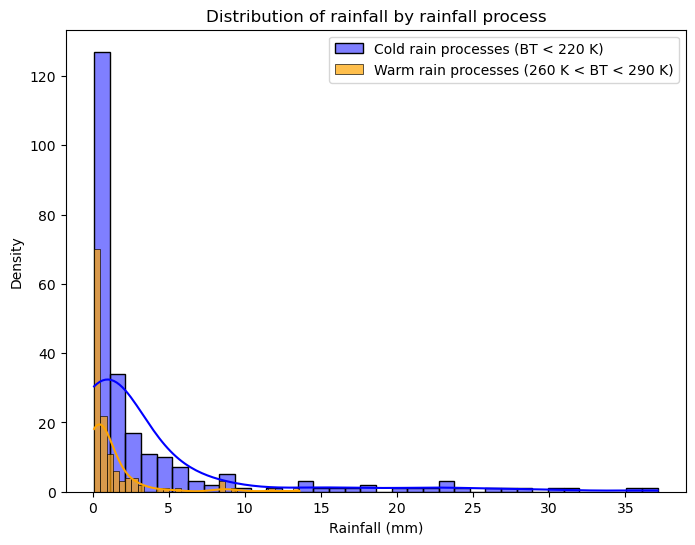

In [64]:
# Example station name
station_name = 'TA00392'

# Combine brightness temperature and rainfall data
df = pd.concat([df_seviri_9[station_name], station_data_tahmo_dict[station_name]], join='inner', axis=1)

# Split data into convective and stratiform based on BT
df = df[df['precipitation (mm)'] > 0.1]

convective_rain = df[df[station_name] < 220]['precipitation (mm)']
stratiform_rain = df[(df[station_name] >= 260) & (df[station_name] <= 290)]['precipitation (mm)']

plt.figure(figsize=(8, 6))
sns.histplot(convective_rain, kde=True, color='blue', label='Cold rain processes (BT < 220 K)')
sns.histplot(stratiform_rain, kde=True, color='orange', label='Warm rain processes (260 K < BT < 290 K)', alpha=0.7)

plt.xlabel('Rainfall (mm)')
plt.ylabel('Density')
plt.title('Distribution of rainfall by rainfall process')

plt.legend()
plt.savefig(f'Stratiform_convective_rainfall_{station_name}.png')
plt.show()
